### Problem Statement :
### This analysis aims to uncover potential causes of mental health disorders by examining the behavioral patterns and histories of affected patients, ### leading to insights for better interventions.


In [1]:
import pandas as pd
import os
from typing import List, Optional, Dict
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix


In [2]:
def fetch_nsduh_data(year: int) -> Optional[pd.DataFrame]:
    url_placeholder = "https://www.datafiles.samhsa.gov/sites/default/files/field-uploads-protected/studies/NSDUH-{year}/NSDUH-{year}-datasets/NSDUH-{year}-DS0001/NSDUH-{year}-DS0001-bundles-with-study-info/NSDUH-{year}-DS0001-bndl-data-tsv.zip"
    
    try:
        url = url_placeholder.format(year=year)
        df = pd.read_csv(url, compression='zip', sep='\t', low_memory=False)
        return df
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")
        return None

In [3]:
def check_parquet_exists(years: List[int], output_dir: str) -> Dict[int, bool]:
    existence_check = {}
    
    for year in years:
        year_path = os.path.join(output_dir, f'year={year}')
        existence_check[year] = os.path.exists(year_path)
    
    return existence_check

In [4]:
def write_parquet(df: pd.DataFrame, year: int, output_dir: str, overwrite: bool = False) -> None:
    try:
        year_dir = os.path.join(output_dir, f'year={year}')
        if overwrite and os.path.exists(year_dir):
            shutil.rmtree(year_dir)  # Remove existing directory to start fresh

        df['year'] = year  # Add the year column for partitioning
        # Write data to Parquet format with partitioning
        df.to_parquet(output_dir, partition_cols=['year'], index=False)
        
        print(f"Data for year {year} successfully saved to Parquet format in {output_dir}")
    except Exception as e:
        print(f"Error saving data to Parquet for year {year}: {e}")

In [5]:
def data_fetch(years_to_fetch: List[int], output_dir: str, overwrite: bool = False) -> None:
    try:
        for year in years_to_fetch:
            if not overwrite and os.path.exists(os.path.join(output_dir, f'year={year}')):
                print(f"Data for year {year} already exists. Skipping.")
                continue

            df = fetch_nsduh_data(year)
            if df is not None:
                print(f"Successfully fetched data for year: {year}")
                write_parquet(df, year, output_dir, overwrite)
                del df  # Remove the DataFrame from memory
                gc.collect()  # Force garbage collection

        print("All requested years processed.")
    except Exception as e:
        print(f"An unexpected error occurred in the data_fetch function: {e}")

In [6]:
def read_parquet(input_dir: str, years: Optional[List[int]] = None) -> pd.DataFrame:
    data_frames = []
    available_years = [int(d.split('=')[1]) for d in os.listdir(input_dir) if d.startswith('year=')]
    years_to_read = years if years is not None else available_years

    for year in years_to_read:
        year_path = os.path.join(input_dir, f'year={year}')
        if os.path.exists(year_path):
            df = pd.read_parquet(year_path)

            # Convert data types to reduce memory usage
            for col in df.select_dtypes(include=['float64']).columns:
                df[col] = df[col].astype('float32')

            data_frames.append(df)
        else:
            print(f"Warning: No data found for year {year}")

    if data_frames:
        combined_df = pd.concat(data_frames, ignore_index=True)
        return combined_df
    else:
        print("Warning: No data was loaded.")
        return pd.DataFrame()

In [7]:
if __name__ == "__main__":
    years = [2015, 2016, 2017, 2018, 2019] 
    output_directory = "../data/DS/NSDUH"    
    data_fetch(years, output_directory, overwrite=False)
    for year in years:
        df = read_parquet(output_directory, [year])
        if year in df:
            print(f"Data for year {year}:")
            print(df[year].head())
        #del df
        gc.collect()

Data for year 2015 already exists. Skipping.
Data for year 2016 already exists. Skipping.
Data for year 2017 already exists. Skipping.
Data for year 2018 already exists. Skipping.
Data for year 2019 already exists. Skipping.
All requested years processed.


### Name : Rama Rao Vydadi
### Person Number : 50604256

### Question 1: How does socioeconomic status (income, education, employment status) influence the likelihood of experiencing mental health disorders?
### Hypothesis 1: Individuals with lower income are more likely to experience mental health issues or Unemployment is a significant predictor of mental health disorders
### Significance of the question: Understanding the correlation between socio-economic factors and mental health can help identify vulnerable populations and provide support for economically weak population.



### Question2: What role does marijuana use play in the aggravation of mental health disorders?
### Hypothesis 2: Frequent marijuana use is more common in states where marijuana is legalized, and this is associated with a higher prevalence of depression.
### •	Understanding the relationship between marijuana use and mental health will help us to answer sensitive questions like should marijuana be banned all over the world




### Question 3: What role does hallucinogens play in mental health disorders?
### Hypothesis 3: Unregulated use of hallucinogens can cause mental health problems like anxiety and depression.
### •	Understanding the relationship between use of various hallucinogens and mental health will suggest us to regulate the supply of medical hallucinogens


#We will first perform the basic data cleaning steps and then perform EDA 

In [8]:
df.head()

,QUESTID2,FILEDATE,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,...,POVERTY3,TOOLONG,TROUBUND,PDEN10,COUTYP4,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP
0,43295143,10/09/2020,1,99,99,13,9999,99,4,93,...,3.0,2,2,2,2,2,2,6613.865723,40004,2
1,65095143,10/09/2020,2,99,99,991,9991,91,91,91,...,3.0,2,2,2,2,2,2,6321.580566,40003,1
2,49405143,10/09/2020,1,99,99,22,9999,99,4,93,...,3.0,2,2,2,2,2,2,5045.607422,40008,1
3,51015143,10/09/2020,2,99,99,991,9991,91,91,91,...,1.0,2,2,2,2,2,2,2419.558838,40031,1
4,31825143,10/09/2020,2,99,99,991,9991,91,91,91,...,3.0,2,2,2,2,2,2,575.225464,40010,2


In [9]:
df.shape

(56136, 2741)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56136 entries, 0 to 56135
Columns: 2741 entries, QUESTID2 to VEREP
dtypes: float32(407), int64(2332), object(2)
memory usage: 1.1+ GB


In [11]:
df.describe()

,QUESTID2,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,CG30EST,...,POVERTY3,TOOLONG,TROUBUND,PDEN10,COUTYP4,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP
count,5.613600e+04,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,...,55609.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000
mean,5.434607e+07,1.542700,78.595554,78.605458,550.575816,9840.048846,92.951600,50.651080,80.111248,92.784915,...,2.427179,2.173650,2.199854,1.662997,1.747827,1.982827,1.982560,4902.758301,40025.570899,1.504400
std,2.563167e+07,0.498178,39.056828,39.037478,485.236660,1099.156156,12.225758,43.980321,26.734751,4.208800,...,0.776759,4.797938,4.794185,0.627146,0.762371,0.129915,0.130904,5952.114746,14.388113,0.499985
min,1.000945e+07,1.000000,1.000000,1.000000,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.581148,40001.000000,1.000000
25%,3.198245e+07,1.000000,99.000000,99.000000,16.000000,9991.000000,91.000000,3.000000,91.000000,91.000000,...,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1262.476593,40013.000000,1.000000
50%,5.403939e+07,2.000000,99.000000,99.000000,991.000000,9991.000000,91.000000,91.000000,91.000000,91.000000,...,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2855.374878,40025.000000,2.000000
75%,7.625105e+07,2.000000,99.000000,99.000000,991.000000,9999.000000,99.000000,91.000000,93.000000,93.000000,...,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,6076.500732,40038.000000,2.000000
max,9.999669e+07,2.000000,99.000000,99.000000,997.000000,9999.000000,99.000000,91.000000,98.000000,99.000000,...,3.000000,98.000000,98.000000,3.000000,3.000000,2.000000,2.000000,77284.484375,40050.000000,2.000000


In [12]:
df.columns

Index(['QUESTID2', 'FILEDATE', 'CIGEVER', 'CIGOFRSM', 'CIGWILYR', 'CIGTRY',
       'CIGYFU', 'CIGMFU', 'CIGREC', 'CIG30USE',
       ...
       'POVERTY3', 'TOOLONG', 'TROUBUND', 'PDEN10', 'COUTYP4', 'MAIIN102',
       'AIIND102', 'ANALWT_C', 'VESTR', 'VEREP'],
      dtype='object', length=2741)

In [13]:
filtered_df=df.copy()

Selecting only required columns from the entire dataset (This is an iterative step after performing EDA)

In [14]:
desired_columns = [
    'QUESTID2', 'IRWRKSTAT', 'IREDUHIGHST2', 'INCOME', 'IRSEX', 'MJEVER',
    'PNRANYLIF', 'COUTYP4', 'MEDMJPA2', 'DSTCHR30', 'ADDPREV', 'LSD', 'PCP', 'PEYOTE', 'MESC', 'PSILCY', 'ECSTMOLLY', 'KETMINESK', 'DMTAMTFXY', 'SALVIADIV', 'HALLUCOTH'
]

filtered_df = df[desired_columns]



In [15]:
#We have various hallucinogens in our dataset we can standardize the mapping and remove the unwanted data 
#like "Dont know", "Refused" etc with nan values 

In [16]:
lsd_mapping = {
    1: 'Yes',  # "Yes"
    2: 'No',   # "No"
    3: 'Yes',  # "Yes logically assigned"
    91: 'No',  # "Never used hallucinogens"
    94: np.nan,  # "Don't know" replaced with NaN
    97: np.nan   # "Refused" replaced with NaN
}

# Apply the mapping to the 'LSD' column
filtered_df['LSD'] = filtered_df['LSD'].map(lsd_mapping)

C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\1422645912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LSD'] = filtered_df['LSD'].map(lsd_mapping)


In [17]:
#we can create similar mapping for all hallucinogens

In [18]:
substance_mapping = {
    1: 'Yes',  # "Yes"
    2: 'No',   # "No"
    91: 'No',  # "Never used hallucinogens"
    94: np.nan,  # "Don't know" replaced with NaN
    97: np.nan   # "Refused" replaced with NaN
}

substance_columns = ['PCP', 'PEYOTE', 'MESC', 'PSILCY', 'ECSTMOLLY', 'KETMINESK', 'DMTAMTFXY', 'SALVIADIV', 'HALLUCOTH']

for col in substance_columns:
    filtered_df[col] = filtered_df[col].map(substance_mapping)

C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\497884309.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].map(substance_mapping)


In [19]:
# Since we have a lot of hallucinogens we can generalize the use of them by creating a new column which will have yes if any one of the 
#hallucinogens in dataset is used

In [20]:
hallucinogen_columns = ['LSD', 'PCP', 'PEYOTE', 'MESC', 'PSILCY', 'ECSTMOLLY', 'KETMINESK', 'DMTAMTFXY', 'SALVIADIV', 'HALLUCOTH']

filtered_df['hallucinogens'] = filtered_df[hallucinogen_columns].apply(
    lambda row: 'Yes' if 'Yes' in row.values else ('No' if all(val == 'No' for val in row.values) else np.nan), axis=1
)

C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\3382138147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['hallucinogens'] = filtered_df[hallucinogen_columns].apply(


In [21]:
# Now only considering hallucination column created in filtered_df
desired_columns = [
    'QUESTID2', 'IRWRKSTAT', 'IREDUHIGHST2', 'INCOME', 'IRSEX', 'MJEVER',
    'PNRANYLIF', 'COUTYP4', 'MEDMJPA2', 'DSTCHR30', 'ADDPREV', 'hallucinogens' ]

filtered_df = filtered_df[desired_columns]



### Data Cleaning

In [22]:
filtered_df.head()

,QUESTID2,IRWRKSTAT,IREDUHIGHST2,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV,hallucinogens
0,43295143,1,11,4,1,1,1,2,2,3,1,No
1,65095143,1,11,4,2,2,1,2,1,5,1,No
2,49405143,1,11,4,1,1,1,2,1,5,2,No
3,51015143,4,6,1,2,2,1,2,1,4,2,No
4,31825143,4,7,4,1,2,2,2,1,4,1,No


### Handling Special codes like Bad Data, Legitimate Skip etc in depression column which does not add value to the analysis

Replace special codes which does not add value with NaN values
85: 'Bad Data',
97: 'Refused',
98: 'Blank',
99: 'Legitimate Skip'

In [23]:

filtered_df['ADDPREV'].replace([85, 97, 98, 99], np.nan, inplace=True)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\2321724339.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['ADDPREV'].replace([85, 97, 98, 99], np.nan, inplace=True)


In [24]:
filtered_df['ADDPREV'].unique()

array([ 1.,  2., nan, 94.])

In the IRWRKSTAT (EMPLOYMENT STATUS) column - 99 indicates 12-14 year olds, this data might not be useful for analysis hence we can remove this data as these people might also be having some income, since we cannot say the exact income level it is better to drop these values 

In [25]:

filtered_df['IRWRKSTAT'].replace([99], np.nan, inplace=True)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\753615126.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['IRWRKSTAT'].replace([99], np.nan, inplace=True)


Since we have more than 11 levels of education in the dataset, we can categorize the education levels into 3 different levels which make more sense i.e Primary, Secondary and Higher education based on the grade studying

In [26]:
# Define a function to categorize the education levels
def categorize_education(value):
    if value < 7:
        return 'primary education'
    elif value in [8, 9]:
        return 'intermediate education'
    else:
        return 'higher education'

filtered_df['IREDUHIGHST2'] = filtered_df['IREDUHIGHST2'].apply(categorize_education)


In [27]:
filtered_df.head()

,QUESTID2,IRWRKSTAT,IREDUHIGHST2,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV,hallucinogens
0,43295143,1.0,higher education,4,1,1,1,2,2,3,1.0,No
1,65095143,1.0,higher education,4,2,2,1,2,1,5,1.0,No
2,49405143,1.0,higher education,4,1,1,1,2,1,5,2.0,No
3,51015143,4.0,primary education,1,2,2,1,2,1,4,2.0,No
4,31825143,4.0,higher education,4,1,2,2,2,1,4,1.0,No


MJEVER contains 94 and 97 which are dont know and refused to answer, these rows are not useful in our analysis hence we can exclude this data

In [28]:

filtered_df['MJEVER'].replace([94, 97], np.nan, inplace=True)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\3512628858.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['MJEVER'].replace([94, 97], np.nan, inplace=True)


In [29]:
#Pain releiver use in lifetime 5 indicates logically assigned yes which means this value is logically made as yes, so we can replace this 
#with 1 in the final data

In [30]:
filtered_df['PNRANYLIF'].replace(5, 1, inplace=True)

C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\422161004.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['PNRANYLIF'].replace(5, 1, inplace=True)


In [31]:
#replcaing values which are not useful with NA
filtered_df['PNRANYLIF'].replace([94, 97, 98], np.nan, inplace=True)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\3256104701.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['PNRANYLIF'].replace([94, 97, 98], np.nan, inplace=True)


In the column How often do you feel sad, there are many columns which cannot be used for analysis we can replace them with NaN

In [32]:
#replcaing values which are not useful with NA
filtered_df['DSTCHR30'].replace([85, 94, 97, 98, 99], np.nan, inplace=True)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\1097070963.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['DSTCHR30'].replace([85, 94, 97, 98, 99], np.nan, inplace=True)


In [33]:
filtered_df.head()

,QUESTID2,IRWRKSTAT,IREDUHIGHST2,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV,hallucinogens
0,43295143,1.0,higher education,4,1,1.0,1.0,2,2,3.0,1.0,No
1,65095143,1.0,higher education,4,2,2.0,1.0,2,1,5.0,1.0,No
2,49405143,1.0,higher education,4,1,1.0,1.0,2,1,5.0,2.0,No
3,51015143,4.0,primary education,1,2,2.0,1.0,2,1,4.0,2.0,No
4,31825143,4.0,higher education,4,1,2.0,2.0,2,1,4.0,1.0,No


In [34]:
#Removal of duplicates from the data frame
filtered_df.drop_duplicates(inplace=True)

In [35]:
#Set display options to have 2 decimals to have proper scale for future operations
pd.options.display.float_format = '{:.2f}'.format

In [36]:
filtered_df.describe()

,QUESTID2,IRWRKSTAT,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV
count,56136.00,49581.00,56136.00,56136.00,56097.00,55670.00,56136.00,56136.00,42411.00,42508.00
mean,54346070.01,2.22,2.72,1.52,1.56,1.49,1.75,1.30,4.37,1.89
std,25631667.47,1.30,1.14,0.50,0.50,0.50,0.76,0.46,0.98,4.59
min,10009454.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,31982452.50,1.00,2.00,1.00,1.00,1.00,1.00,1.00,4.00,1.00
50%,54039390.00,2.00,3.00,2.00,2.00,1.00,2.00,1.00,5.00,2.00
75%,76251052.50,4.00,4.00,2.00,2.00,2.00,2.00,2.00,5.00,2.00
max,99996688.00,4.00,4.00,2.00,2.00,2.00,3.00,2.00,5.00,94.00


In [37]:
education_mapping = {
    'higher education': 3,
    'primary education': 1,
    'intermediate education': 2
}
filtered_df['IREDUHIGHST2'] = filtered_df['IREDUHIGHST2'].replace(education_mapping)

C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\4283032743.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df['IREDUHIGHST2'] = filtered_df['IREDUHIGHST2'].replace(education_mapping)


In [38]:
filtered_df.head()


,QUESTID2,IRWRKSTAT,IREDUHIGHST2,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV,hallucinogens
0,43295143,1.00,3,4,1,1.00,1.00,2,2,3.00,1.00,No
1,65095143,1.00,3,4,2,2.00,1.00,2,1,5.00,1.00,No
2,49405143,1.00,3,4,1,1.00,1.00,2,1,5.00,2.00,No
3,51015143,4.00,1,1,2,2.00,1.00,2,1,4.00,2.00,No
4,31825143,4.00,3,4,1,2.00,2.00,2,1,4.00,1.00,No


In [39]:
filtered_df.shape

(56136, 12)

In [40]:
#Since we have already replaced unnecessary values with NaN we can drop these values as they are no longer useful


In [41]:
null_values = filtered_df.isnull().sum()

print(null_values)


QUESTID2             0
IRWRKSTAT         6555
IREDUHIGHST2         0
INCOME               0
IRSEX                0
MJEVER              39
PNRANYLIF          466
COUTYP4              0
MEDMJPA2             0
DSTCHR30         13725
ADDPREV          13628
hallucinogens      245
dtype: int64


In [42]:
filtered_df_cleaned = filtered_df.dropna(subset=['IRWRKSTAT', 'DSTCHR30', 'ADDPREV', 'PNRANYLIF','MJEVER' ])



In [43]:
filtered_df_cleaned.shape

(42166, 12)

In [44]:
filtered_df_cleaned['IRWRKSTAT'].unique()

array([1., 4., 3., 2.])

In [45]:
irwrkstat_mapping = {
    1: 'Employed full time',
    2: 'Employed part time',
    3: 'Unemployed',
    4: 'Other (incl. not in labor force)',
    99: '12–14 year olds'
}

filtered_df_cleaned['IRWRKSTAT'] = filtered_df_cleaned['IRWRKSTAT'].map(irwrkstat_mapping)




C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\2354628446.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['IRWRKSTAT'] = filtered_df_cleaned['IRWRKSTAT'].map(irwrkstat_mapping)


In [46]:
filtered_df_cleaned[['IRWRKSTAT']].head()

,IRWRKSTAT
0,Employed full time
1,Employed full time
2,Employed full time
3,Other (incl. not in labor force)
4,Other (incl. not in labor force)


In [47]:
income_mapping = {
    1: 'Less than $20,000',
    2: '$20,000 - $49,999',
    3: '$50,000 - $74,999',
    4: '$75,000 or more'
}

filtered_df_cleaned['INCOME'] = filtered_df_cleaned['INCOME'].map(income_mapping)



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\4064115886.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['INCOME'] = filtered_df_cleaned['INCOME'].map(income_mapping)


In [48]:
filtered_df_cleaned[['INCOME']].head()

,INCOME
0,"$75,000 or more"
1,"$75,000 or more"
2,"$75,000 or more"
3,"Less than $20,000"
4,"$75,000 or more"


In [49]:

gender_mapping = {
    1: 'Male',
    2: 'Female'
}

filtered_df_cleaned['IRSEX'] = filtered_df_cleaned['IRSEX'].map(gender_mapping)



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\4015784729.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['IRSEX'] = filtered_df_cleaned['IRSEX'].map(gender_mapping)


In [50]:
filtered_df_cleaned.head()

,QUESTID2,IRWRKSTAT,IREDUHIGHST2,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV,hallucinogens
0,43295143,Employed full time,3,"$75,000 or more",Male,1.00,1.00,2,2,3.00,1.00,No
1,65095143,Employed full time,3,"$75,000 or more",Female,2.00,1.00,2,1,5.00,1.00,No
2,49405143,Employed full time,3,"$75,000 or more",Male,1.00,1.00,2,1,5.00,2.00,No
3,51015143,Other (incl. not in labor force),1,"Less than $20,000",Female,2.00,1.00,2,1,4.00,2.00,No
4,31825143,Other (incl. not in labor force),3,"$75,000 or more",Male,2.00,2.00,2,1,4.00,1.00,No


In [51]:
filtered_df_cleaned['IREDUHIGHST2'].unique()

array([3, 1, 2])

In [52]:
# Define a function to categorize the education levels
def categorize_education(value):
    if value==1:
        return 'primary education'
    elif value==2:
        return 'High School education'
    else:
        return 'College Degree'

filtered_df_cleaned['IREDUHIGHST2'] = filtered_df_cleaned['IREDUHIGHST2'].apply(categorize_education)



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\809615653.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['IREDUHIGHST2'] = filtered_df_cleaned['IREDUHIGHST2'].apply(categorize_education)


In [53]:
filtered_df_cleaned['IREDUHIGHST2'].unique()

array(['College Degree', 'primary education', 'High School education'],
      dtype=object)

In [54]:

mj_mapping = {
    1: 'Yes',
    2: 'No'
}

filtered_df_cleaned['MJEVER'] = filtered_df_cleaned['MJEVER'].map(mj_mapping)



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\3622425528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['MJEVER'] = filtered_df_cleaned['MJEVER'].map(mj_mapping)


In [55]:

mj_mapping = {
    1.00: 'Yes',
    2.00: 'No'
}


filtered_df_cleaned['PNRANYLIF'] = filtered_df_cleaned['PNRANYLIF'].map(mj_mapping)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\2351626243.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['PNRANYLIF'] = filtered_df_cleaned['PNRANYLIF'].map(mj_mapping)


In [56]:

metro_mapping = {
    1: 'Large Metro',
    2: 'Small Metro',
    3: 'Non Metro'
}


filtered_df_cleaned['COUTYP4'] = filtered_df_cleaned['COUTYP4'].map(metro_mapping)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\1158216921.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['COUTYP4'] = filtered_df_cleaned['COUTYP4'].map(metro_mapping)


In [57]:
mapping = {
    1: 'All of the time',
    2: 'Most of the time',
    3: 'Some of the time',
    4: 'A little of the time',
    5: 'None of the time',
    99: 'Legitimate skip'
}
filtered_df_cleaned['DSTCHR30'] = filtered_df_cleaned['DSTCHR30'].map(mapping)




C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\2251930963.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['DSTCHR30'] = filtered_df_cleaned['DSTCHR30'].map(mapping)


In [58]:
filtered_df_cleaned['ADDPREV'].unique()

array([ 1.,  2., 94.])

In [59]:
mapping = {
    1.00: 'Yes',
    2.00: 'No',
    94.00: 'No'
}
filtered_df_cleaned['ADDPREV'] = filtered_df_cleaned['ADDPREV'].map(mapping)




C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\3008980501.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['ADDPREV'] = filtered_df_cleaned['ADDPREV'].map(mapping)


In [60]:
mapping = {
    1: 'Yes',
    2: 'No',
}
filtered_df_cleaned['MEDMJPA2'] = filtered_df_cleaned['MEDMJPA2'].map(mapping)




C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\88440773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['MEDMJPA2'] = filtered_df_cleaned['MEDMJPA2'].map(mapping)


Renaming columns for better readability

In [61]:

column_mapping = {
    'IRWRKSTAT': 'Employment',
    'IREDUHIGHST2': 'education',
    'INCOME': 'income',
    'IRSEX': 'sexual orientation',
    'MJEVER': 'Ever used marijuana',
    'PNRANYLIF': 'ANY PAIN RELIEVER USE IN LIFETIME',
    'COUTYP4': 'COUNTY METRO/NONMETRO STATUS',
    'MEDMJPA2': 'STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVIEW',
    'DSTCHR30': 'HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP',
    'ADDPREV': 'SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD'
}

filtered_df_cleaned.rename(columns=column_mapping, inplace=True)
filtered_df__cleaned = filtered_df_cleaned.copy()
filtered_df__cleaned['Mental_Health_Disorder'] = filtered_df__cleaned['SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD'].apply(lambda x: 1 if x == 'Yes' else 0)
filtered_df__cleaned = filtered_df__cleaned.drop(columns=['SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD'])



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\48733474.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned.rename(columns=column_mapping, inplace=True)


In [62]:
e_df = pd.get_dummies(filtered_df__cleaned, columns=['sexual orientation','STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVIEW', 'Ever used marijuana','COUNTY METRO/NONMETRO STATUS', 'ANY PAIN RELIEVER USE IN LIFETIME', 'hallucinogens', 'Employment','education','income'], drop_first=True)
e_df = e_df.replace({True: 1, False: 0})
target_order = {"None of the time": 0, "A little of the time": 1, "Some of the time": 2, "Most of the time": 3, "All of the time": 4}
e_df['HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP'] = e_df['HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP'].map(target_order)
df = e_df.copy()
req_X_cols = [w for w in df.columns if w not in ['Mental_Health_Disorder', 'QUESTID2']]

C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\1325856201.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  e_df = e_df.replace({True: 1, False: 0})


In [63]:
X = df[req_X_cols]
X = df.drop(columns=['Mental_Health_Disorder'])
y = df['Mental_Health_Disorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.86, random_state=42)

In [64]:



model = GradientBoostingClassifier()
model.fit(X_train.drop(columns=['QUESTID2']), y_train) 
y_pred = model.predict(X_test.drop(columns=['QUESTID2']))
mmi = [i for i, (actual, predicted) in enumerate(zip(y_test, y_pred)) if actual != predicted]
mmr = X_test.iloc[mmi].copy()
mmr['True Label'] = y_test.iloc[mmi].values
mmr['Predicted Label'] = y_pred[mmi]

print("\nRecords where predictions do not match actual values:")
mmr.shape



Records where predictions do not match actual values:


(8918, 19)

In [65]:
filtered_df_cleaned.shape

(42166, 12)

In [66]:

matching_ids = mmr['QUESTID2'].values
filtered_df_cleaned.loc[filtered_df_cleaned['QUESTID2'].isin(matching_ids), 'QUESTID2'] = np.nan



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\907183047.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Depression')


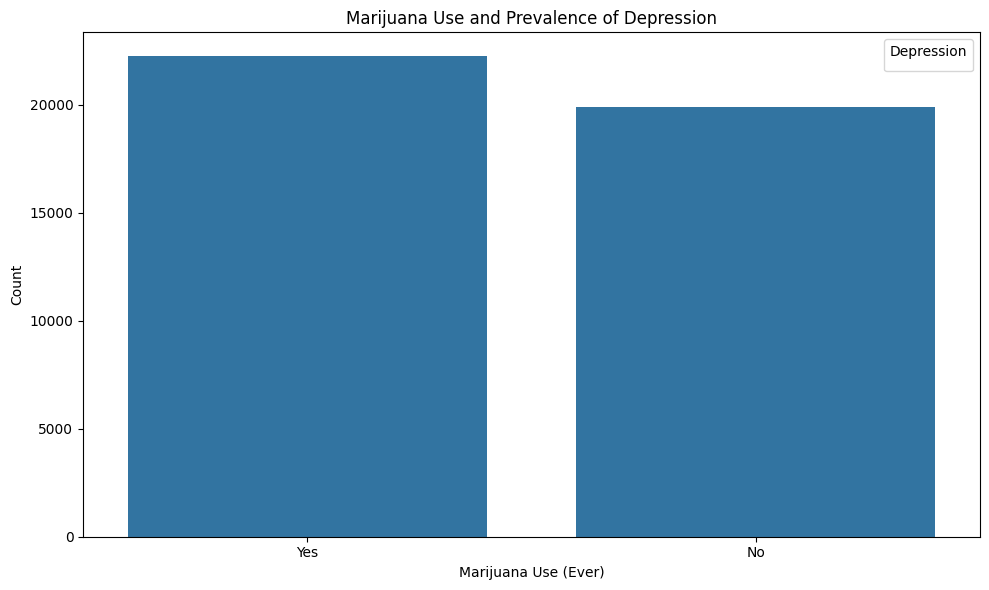

In [67]:
# Relationship between marijuana use and depression
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df__cleaned, x='Ever used marijuana')
plt.title('Marijuana Use and Prevalence of Depression')
plt.xlabel('Marijuana Use (Ever)')
plt.ylabel('Count')
plt.legend(title='Depression')
plt.tight_layout()
plt.show()

C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\1524618430.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Depression')


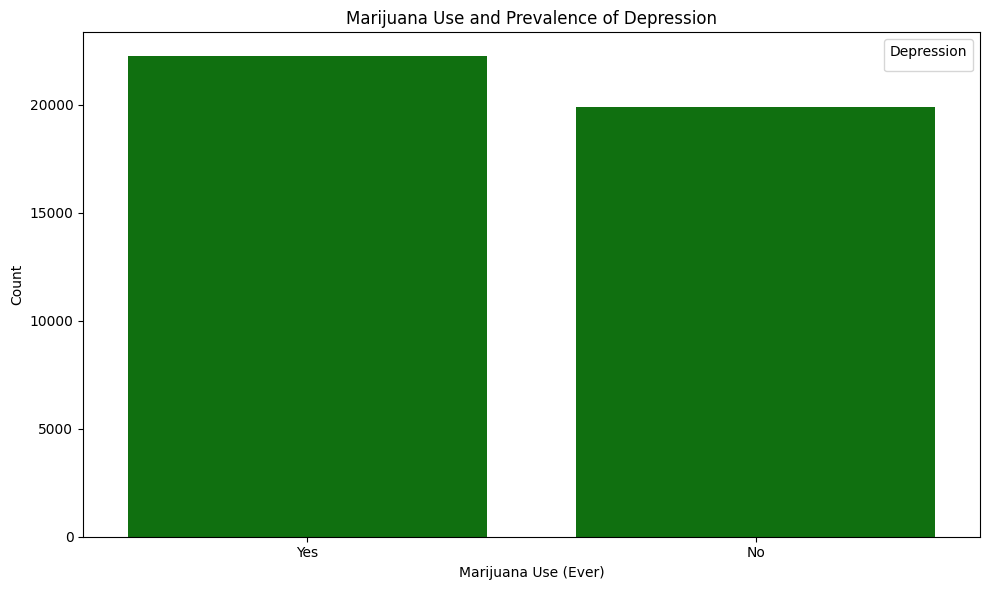

In [68]:
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df__cleaned, x='Ever used marijuana', color='green')
plt.title('Marijuana Use and Prevalence of Depression')
plt.xlabel('Marijuana Use (Ever)')
plt.ylabel('Count')
plt.legend(title='Depression')
plt.tight_layout()
plt.show()


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\1276217604.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Depression')


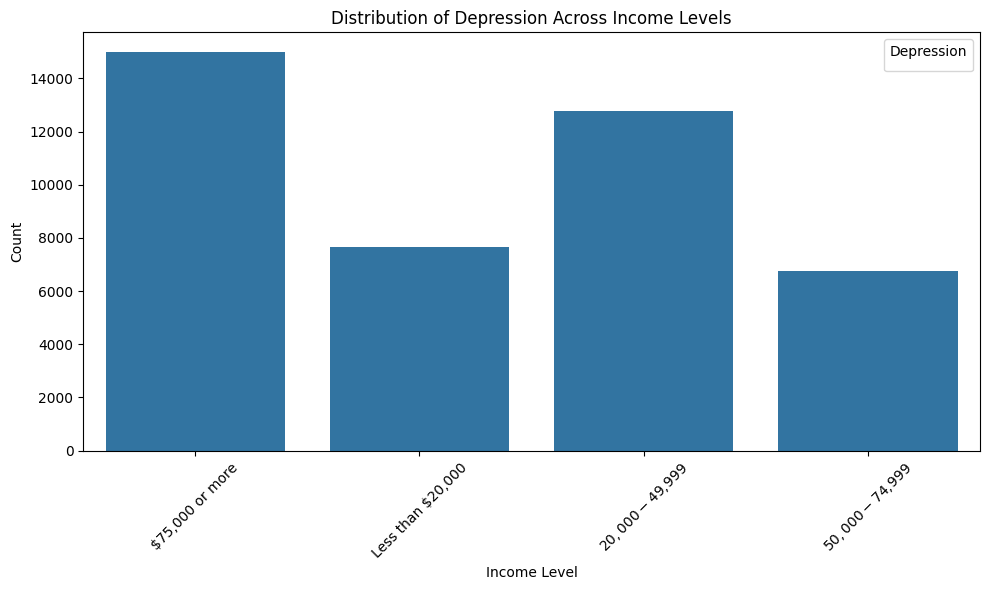

In [69]:
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df_cleaned, x='income')
plt.title('Distribution of Depression Across Income Levels')
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Depression')
plt.tight_layout()
plt.show()



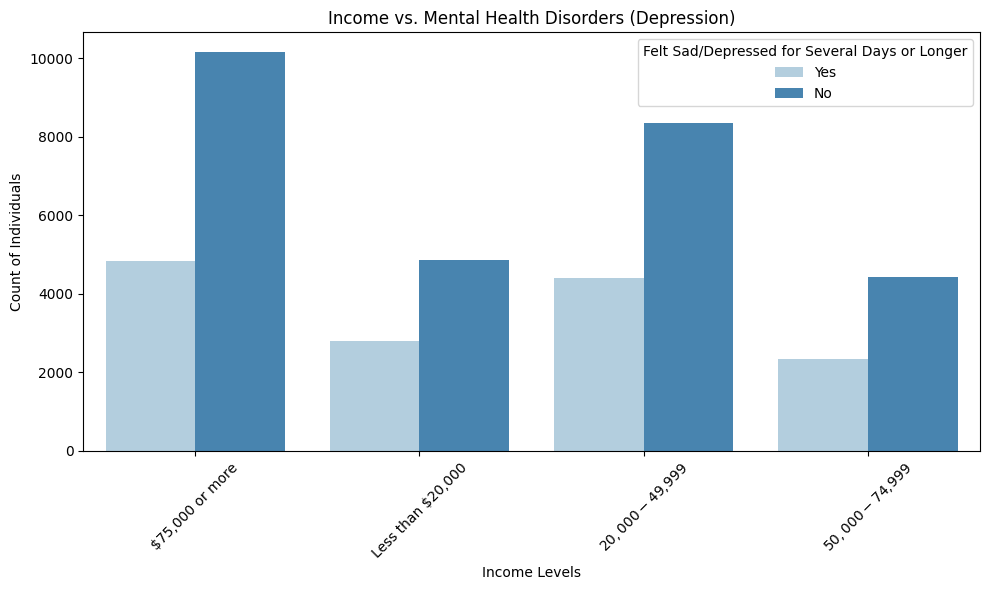

In [70]:
# Question 1: How does socioeconomic status (income, education, employment status) influence mental health?
# Bar plot to show the distribution of depression (Sadness) across different income levels.

# Create a plot for the influence of income on experiencing mental health disorders (depression)
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df_cleaned, x='income', hue='SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD', palette="Blues")
plt.title('Income vs. Mental Health Disorders (Depression)')
plt.xlabel('Income Levels')
plt.ylabel('Count of Individuals')
plt.xticks(rotation=45)
plt.legend(title='Felt Sad/Depressed for Several Days or Longer')
plt.tight_layout()
plt.show()

### Observations:
# From the above graphs we might conclude that people whose income is less than $20,000 (which is the least among the others) are more likely to 
# feel depressed.


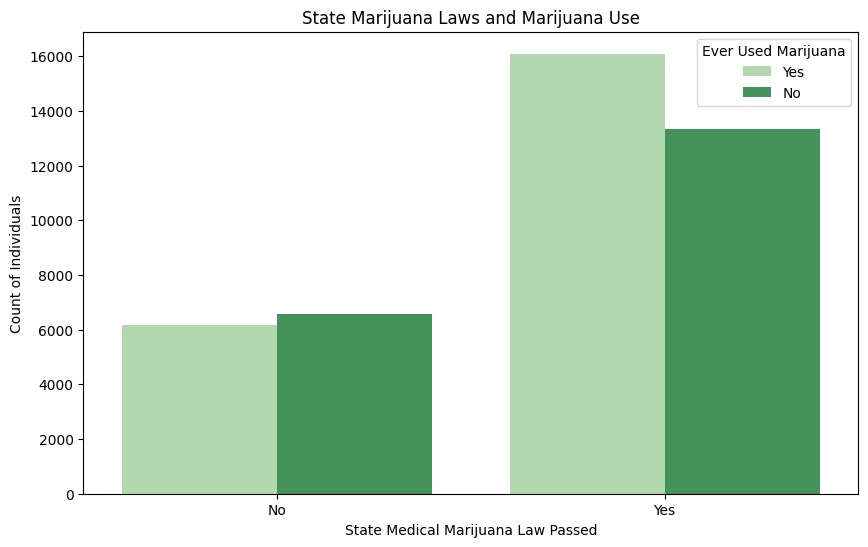

In [71]:
# Question 2: The role of marijuana use in mental health
# We will create a bar plot to see the relation between marijuana use, state marijuana laws, and depression

plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df__cleaned, x='STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVIEW', hue='Ever used marijuana', palette="Greens")
plt.title('State Marijuana Laws and Marijuana Use')
plt.xlabel('State Medical Marijuana Law Passed')
plt.ylabel('Count of Individuals')
plt.legend(title='Ever Used Marijuana')
#plt.tight_layout()
plt.show()



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\907183047.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Depression')


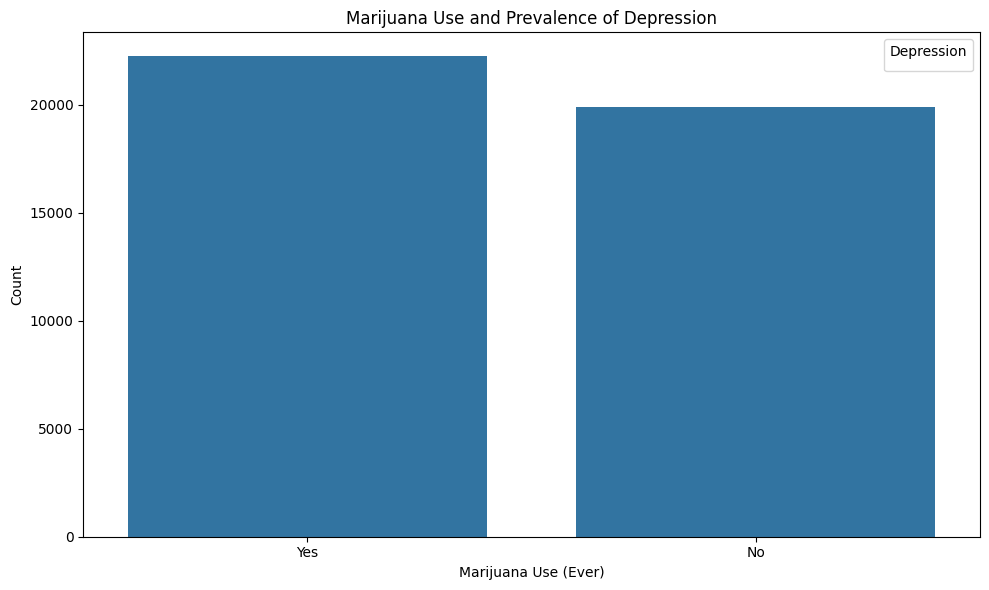

In [72]:
# Relationship between marijuana use and depression
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df__cleaned, x='Ever used marijuana')
plt.title('Marijuana Use and Prevalence of Depression')
plt.xlabel('Marijuana Use (Ever)')
plt.ylabel('Count')
plt.legend(title='Depression')
plt.tight_layout()
plt.show()

### -x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-

### Phase 2 starts here:

### Question1: What role does marijuana use play in the aggravation of mental health disorders?
### Hypothesis 1: Frequent marijuana use is more common in states where marijuana is legalized, and this is associated with a higher prevalence of depression.
### •	Understanding the relationship between marijuana use and mental health will help us to answer sensitive questions like should marijuana be banned all over the world

### Question 2: What role does hallucinogens play in mental health disorders?
### Hypothesis 2: Unregulated use of hallucinogens can cause mental health problems like anxiety and depression.
### •	Understanding the relationship between use of various hallucinogens and mental health will suggest us to regulate the supply of medical hallucinogens

In [73]:
#making a copy of original dataset for analysis for another question
filtered_df_cleaned_org=filtered_df_cleaned.copy()


In [74]:
# Excluding the features which are not relevant to above analysis
columns_to_exclude = ['Employment', 'education', 'income', 'sexual orientation', 'COUNTY METRO/NONMETRO STATUS']

# Select columns that are not in the exclusion list
filtered_df_cleaned = filtered_df_cleaned[[col for col in filtered_df_cleaned.columns if col not in columns_to_exclude]]



In [75]:
filtered_df_cleaned=filtered_df_cleaned.rename(columns={'ANY PAIN RELIEVER USE IN LIFETIME':'PAIN RELIEVER USE', 'hallucinogens':'Hallucinogens usage'})

In [76]:
filtered_df_cleaned = filtered_df_cleaned.dropna()

In [77]:
# We will use the column "SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD" as the output column which will be the final outcome column, we will assume
# "Yes" as experiencing mental health issues and "No" as not experiencing them

In [78]:
filtered_df_cleaned['Mental_Health_Disorder'] = filtered_df_cleaned['SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD'].apply(lambda x: 1 if x == 'Yes' else 0)

# we will drop the original target column as it is already used in above column
filtered_df_cleaned = filtered_df_cleaned.drop(columns=['SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD'])


In [79]:
# converting categorical variables into binary columns using One-hot encoding to make the data suitable for ML algorithms

In [80]:
encoded_df = pd.get_dummies(filtered_df_cleaned, columns=[ 'STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVIEW', 'Ever used marijuana', 'PAIN RELIEVER USE','Hallucinogens usage'], drop_first=True)

encoded_df.head()


,QUESTID2,HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP,Mental_Health_Disorder,STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVIEW_Yes,Ever used marijuana_Yes,PAIN RELIEVER USE_Yes,Hallucinogens usage_Yes
0,43295143.00,Some of the time,1,False,True,True,False
2,49405143.00,None of the time,0,True,True,True,False
3,51015143.00,A little of the time,0,True,False,True,False
6,65565143.00,None of the time,0,True,True,False,False
7,45375143.00,None of the time,0,True,False,True,False


In [81]:
# Converting boolean  values to 1 and 0
encoded_df = encoded_df.replace({True: 1, False: 0})
encoded_df.head()


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\3547169791.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_df = encoded_df.replace({True: 1, False: 0})


,QUESTID2,HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP,Mental_Health_Disorder,STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVIEW_Yes,Ever used marijuana_Yes,PAIN RELIEVER USE_Yes,Hallucinogens usage_Yes
0,43295143.00,Some of the time,1,0,1,1,0
2,49405143.00,None of the time,0,1,1,1,0
3,51015143.00,A little of the time,0,1,0,1,0
6,65565143.00,None of the time,0,1,1,0,0
7,45375143.00,None of the time,0,1,0,1,0


In [82]:
encoded_df['HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP'].unique()

array(['Some of the time', 'None of the time', 'A little of the time',
       'Most of the time', 'All of the time'], dtype=object)

In [83]:
target_order = {
    "None of the time": 0,
    "A little of the time": 1,
    "Some of the time": 2,
    "Most of the time": 3,
    "All of the time": 4
}


encoded_df['HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP'] = encoded_df['HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP'].map(target_order)

encoded_df['HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP'].unique()


array([2, 0, 1, 3, 4])

In [84]:
encoded_df.head()

,QUESTID2,HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP,Mental_Health_Disorder,STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVIEW_Yes,Ever used marijuana_Yes,PAIN RELIEVER USE_Yes,Hallucinogens usage_Yes
0,43295143.00,2,1,0,1,1,0
2,49405143.00,0,0,1,1,1,0
3,51015143.00,1,0,1,0,1,0
6,65565143.00,0,0,1,1,0,0
7,45375143.00,0,0,1,0,1,0


In [85]:
df=encoded_df.copy()
df.head()

,QUESTID2,HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP,Mental_Health_Disorder,STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVIEW_Yes,Ever used marijuana_Yes,PAIN RELIEVER USE_Yes,Hallucinogens usage_Yes
0,43295143.00,2,1,0,1,1,0
2,49405143.00,0,0,1,1,1,0
3,51015143.00,1,0,1,0,1,0
6,65565143.00,0,0,1,1,0,0
7,45375143.00,0,0,1,0,1,0


In [86]:
#Excluding the columns to predict and the ID which is unique for each row
req_X_cols = [w for w in df.columns if w not in ['Mental_Health_Disorder','QUESTID2']]


In [87]:
X = df[req_X_cols]
y = df['Mental_Health_Disorder'] #Outcome


In [88]:
data=df.copy()

### We will calculate Variance Inflation Factor to detect multicollinearity among features
High VIF indicates high multicollinearity, which can negatively impact model performance and interpretation. Hence, we 


In [89]:

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                                             Feature  VIF
0      HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP 1.38
1  STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVI... 1.90
2                            Ever used marijuana_Yes 2.41
3                              PAIN RELIEVER USE_Yes 2.04
4                            Hallucinogens usage_Yes 1.50


 A VIF value greater than 10 indicates high collinearity and this should be removed. However, we can observe that all the features have VIF less than 5 
this indicates that multicollinearity is not an issue in our case

## Model Selection 

### Logistic Regression: 
Mental health data has complex, non-linear relationships between features and the target variable. Since Logistic Regression has a linear decision boundary in the feature space, this model might fail to capture these non-linear interactions adequately.
### Random Forest: 
In this method multiple decision trees are built and merged finally to get accurate and stable predictions. This model is better than logistic regression as it can handle both linear and non-linear relationships well. This model can also reduce overfitting by averaging, but it is computationally expensive.
### Gradient Boosting: 
This is another ensemble technique that builds trees sequentially, with each tree correcting the errors of the previous one. It is known for its high predictive performance but may require careful tuning to avoid overfitting.
### XGBoost
This model is suitable for our case because it can effectively handle complex and non-linear relationships between features. This can also handle class imbalance, making it suitable for real-world datasets. Additionally, it has built-in regularization which prevents overfitting.

In [90]:
X = data.drop(columns=['QUESTID2', 'Mental_Health_Disorder'])
y = data['Mental_Health_Disorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
}

model_performance = {}

for name, model in models.items():
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test) 
    test_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    model_performance[name] = {'Test Accuracy': test_accuracy, 'F1 Score': f1}

performance_df = pd.DataFrame(model_performance).T
performance_df

C:\Users\Rama Rao\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:41:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Test Accuracy,F1 Score
Logistic Regression,0.92,0.85
Random Forest,0.93,0.87
Gradient Boosting,0.93,0.87
XGBoost,0.93,0.87


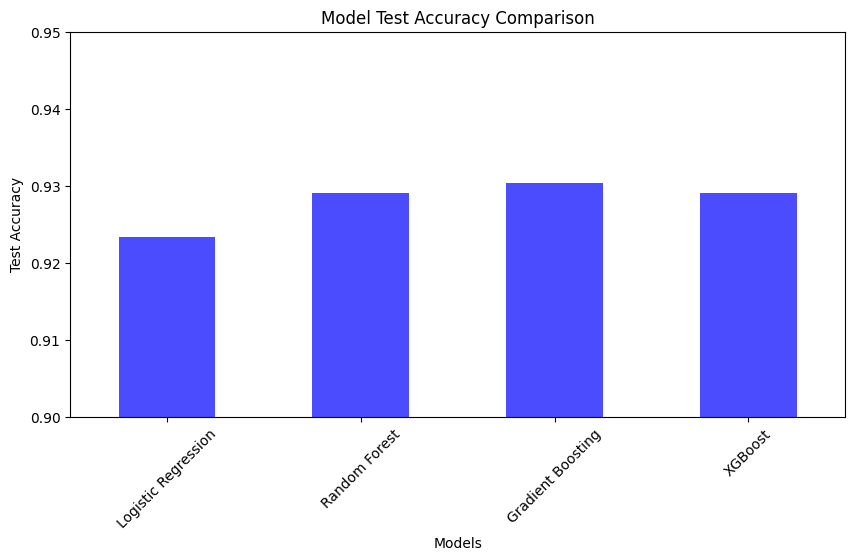

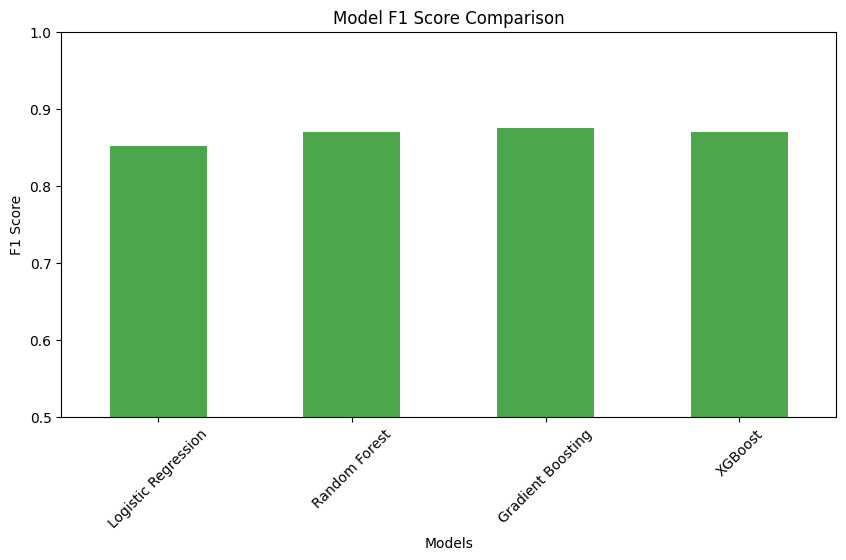

In [91]:
plt.figure(figsize=(10, 5))
performance_df['Test Accuracy'].plot(kind='bar', color='blue', alpha=0.7)
plt.title('Model Test Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.xlabel('Models')
plt.ylim(0.90, 0.95)  # Adjusting the y-axis range to highlight variations
plt.xticks(rotation=45)
plt.show()

# Plotting F1 Score with adjusted y-axis range to highlight differences
plt.figure(figsize=(10, 5))
performance_df['F1 Score'].plot(kind='bar', color='green', alpha=0.7)
plt.title('Model F1 Score Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Models')
plt.ylim(0.5, 1.0)  # Adjusting the y-axis range to highlight variations
plt.xticks(rotation=45)
plt.show()


## Finalizing the model to be used
### Test Accuracy: 
This metric measures overall correctness of the predictions. This will help us to understand how well the model performs on the entire test set.
### F1 Score:
This metric is the harmonic mean of precision and recall, this is useful while dealing with cases having class imbalance issue. This gives a measure of how well the model identifies the positive class.

In case of Logistic Regression, the F1 Score is the lowest among all models evaluated. This indicates that logistic regression might not be useful for balancing precision and recall, which is very important for our case.

Random Forest has slighlty high accuracy and F1 Score compared to Logistic Regression. It can capture non-linear relationships and is more robust. However, this model does not perform as good as Gradient Boosting.

Gradient Boosting achieves the highest Test Accuracy and F1 Score among all the models which we have evaluated. Hence, this is the most effective at correctly predicting both classes and balancing precision and recall.

 XGBoost performs similarly to Random Forest, with the same Test Accuracy and F1 Score. Although it is known for its efficiency and performance, it does not outperform Gradient Boosting in this case.

 ### Conclusion:
 Hence we will choose Gradient Boosting as the final model as it provides the best balance between accuracy and the F1 Score. This is the most suitable option in our case as both performance and the handling of imbalanced classes are important to us.

In [92]:
model = GradientBoostingClassifier()

model.fit(X_train, y_train)

with open('gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('gradient_boosting_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = loaded_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Model Evaluation Metrics:
Accuracy: 0.930421686746988
Precision: 0.860502405130946
Recall: 0.8890115958034235
F1 Score: 0.8745247148288974


In [94]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

y_pred = loaded_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass if applicable
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print(classification_report(y_test, y_pred))


Model Evaluation Metrics:
Accuracy: 0.930421686746988
Precision: 0.9313013589837174
Recall: 0.930421686746988
F1 Score: 0.9307711156191577
Confusion Matrix:
 [[4568  261]
 [ 201 1610]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4829
           1       0.86      0.89      0.87      1811

    accuracy                           0.93      6640
   macro avg       0.91      0.92      0.91      6640
weighted avg       0.93      0.93      0.93      6640



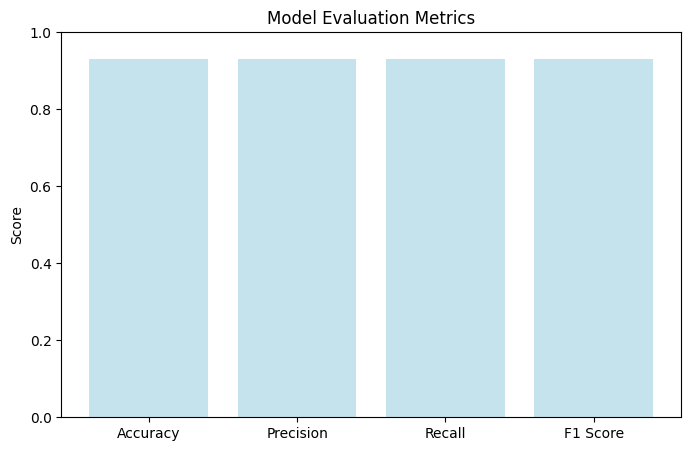

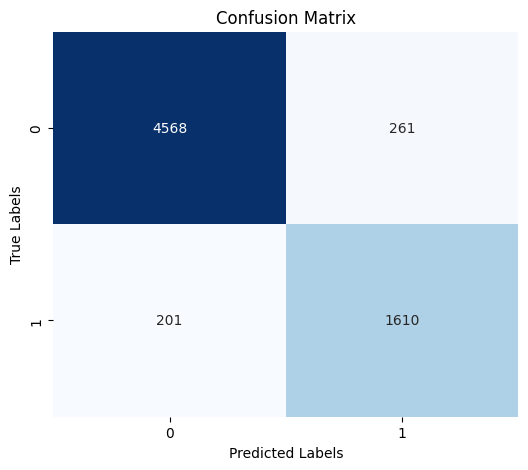

In [95]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color='lightblue', alpha=0.7)
plt.title("Model Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



## Checking the most important features which led to the predictions to evaluate our initial hypothesis

In [96]:
feature_names = X_train.columns

feature_importances = loaded_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
feature_importance = feature_importance_df[feature_importance_df['Feature'] != 'HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP']

top_features = feature_importance.sort_values(by='Importance', ascending=False)

top_feature_names = top_features.head(5)['Feature']
print("Top Features:")
print(top_feature_names)


Top Features:
3                                PAIN RELIEVER USE_Yes
2                              Ever used marijuana_Yes
4                              Hallucinogens usage_Yes
1    STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVI...
Name: Feature, dtype: object


Top Features:
3                                PAIN RELIEVER USE_Yes
2                              Ever used marijuana_Yes
4                              Hallucinogens usage_Yes
1    STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVI...
Name: Feature, dtype: object


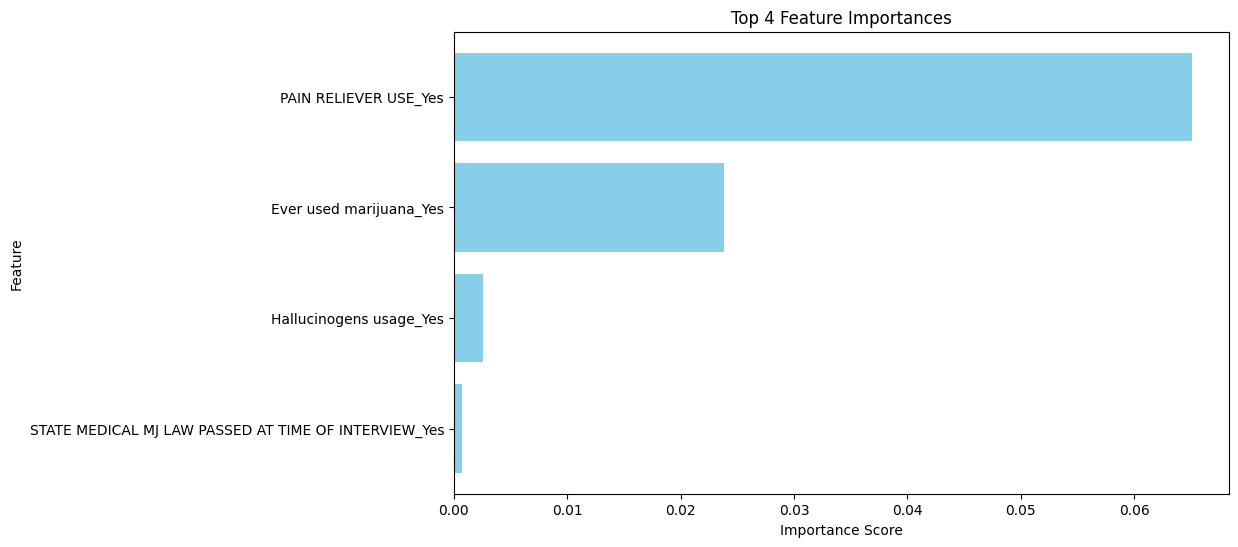

In [97]:
feature_names = X_train.columns
feature_importances = loaded_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
feature_importance = feature_importance_df[feature_importance_df['Feature'] != 'HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP']
top_features = feature_importance.sort_values(by='Importance', ascending=False).head()
top_feature_names = top_features['Feature']
top_importance_values = top_features['Importance']
print("Top Features:")
print(top_feature_names)
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_importance_values, color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 4 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


## From the above data we can conclude the following -
- Frequent marijuana use which is more common in states where marijuana is legalized, and this is associated with a higher prevalence of bad mental health conditions
- Usage of hallucinogens is also associated with bad mental health conditions
- We have observed that pain reliever use is a significant feature in predicting mental health disorders. This suggests that the unregulated use of pain relievers, often for recreational purposes, may contribute to bad mental health. Hence, it is essential to ensure that pain relievers are only accessible through proper prescriptions from authorized medical professionals. 

### Question 3: How does socioeconomic status (income, education, employment status) influence the likelihood of experiencing mental health disorders?
### Hypothesis 1: Individuals with lower income are more likely to experience mental health issues or Unemployment is a significant predictor of mental health disorders
### Significance of the question: Understanding the correlation between socio-economic factors and mental health can help identify vulnerable populations and provide support for economically weak population.

In [98]:
filtered_df_cleaned=filtered_df_cleaned_org.copy()
filtered_df_cleaned.dropna()

,QUESTID2,Employment,education,income,sexual orientation,Ever used marijuana,ANY PAIN RELIEVER USE IN LIFETIME,COUNTY METRO/NONMETRO STATUS,STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVIEW,HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP,SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD,hallucinogens
0,43295143.00,Employed full time,College Degree,"$75,000 or more",Male,Yes,Yes,Small Metro,No,Some of the time,Yes,No
2,49405143.00,Employed full time,College Degree,"$75,000 or more",Male,Yes,Yes,Small Metro,Yes,None of the time,No,No
3,51015143.00,Other (incl. not in labor force),primary education,"Less than $20,000",Female,No,Yes,Small Metro,Yes,A little of the time,No,No
6,65565143.00,Unemployed,High School education,"$75,000 or more",Female,Yes,No,Large Metro,Yes,None of the time,No,No
7,45375143.00,Other (incl. not in labor force),High School education,"$20,000 - $49,999",Male,No,Yes,Non Metro,Yes,None of the time,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...
56125,23883730.00,Employed full time,College Degree,"$75,000 or more",Male,Yes,Yes,Small Metro,Yes,None of the time,No,Yes
56126,55494730.00,Other (incl. not in labor force),College Degree,"$20,000 - $49,999",Female,No,Yes,Small Metro,Yes,None of the time,No,No
56127,21894730.00,Other (incl. not in labor force),High School education,"$20,000 - $49,999",Female,No,No,Large Metro,Yes,Some of the time,Yes,No
56129,61414730.00,Employed full time,College Degree,"$75,000 or more",Female,Yes,Yes,Small Metro,No,A little of the time,Yes,No


In [99]:
# Excluding the features which are not relevant to our analysis
columns_to_exclude = ['sexual orientation', 'Ever used marijuana', 'ANY PAIN RELIEVER USE IN LIFETIME', 'STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVIEW', 'hallucinogens']
filtered_df_cleaned = filtered_df_cleaned[[col for col in filtered_df_cleaned.columns if col not in columns_to_exclude]]

In [100]:
filtered_df_cleaned['Mental_Health_Disorder'] = filtered_df_cleaned['SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD'].apply(lambda x: 1 if x == 'Yes' else 0)

filtered_df_cleaned = filtered_df_cleaned.drop(columns=['SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD'])


In [101]:
encoded_df = pd.get_dummies(filtered_df_cleaned, columns=[ 'Employment', 'education', 'income','COUNTY METRO/NONMETRO STATUS'], drop_first=True)

encoded_df=encoded_df.dropna()


In [102]:
encoded_df = encoded_df.replace({True: 1, False: 0})
encoded_df.head()

C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_17120\794848686.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_df = encoded_df.replace({True: 1, False: 0})


,QUESTID2,HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP,Mental_Health_Disorder,Employment_Employed part time,Employment_Other (incl. not in labor force),Employment_Unemployed,education_High School education,education_primary education,"income_$50,000 - $74,999","income_$75,000 or more","income_Less than $20,000",COUNTY METRO/NONMETRO STATUS_Non Metro,COUNTY METRO/NONMETRO STATUS_Small Metro
0,43295143.00,Some of the time,1,0,0,0,0,0,0,1,0,0,1
2,49405143.00,None of the time,0,0,0,0,0,0,0,1,0,0,1
3,51015143.00,A little of the time,0,0,1,0,0,1,0,0,1,0,1
6,65565143.00,None of the time,0,0,0,1,1,0,0,1,0,0,0
7,45375143.00,None of the time,0,0,1,0,1,0,0,0,0,1,0


In [103]:
order = {
    "None of the time": 0,
    "A little of the time": 1,
    "Some of the time": 2,
    "Most of the time": 3,
    "All of the time": 4
}
encoded_df['HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP'] = encoded_df['HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP'].map(order)
encoded_df['HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP'].unique()


array([2, 0, 1, 3, 4])

In [104]:
encoded_df=encoded_df.dropna()

In [105]:
df=encoded_df.copy()
req_X_cols = [w for w in df.columns if w not in ['Mental_Health_Disorder','QUESTID2']]
X = df[req_X_cols]
y = df['Mental_Health_Disorder'] #Outcome

data=df.copy()

In [106]:
data

,QUESTID2,HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP,Mental_Health_Disorder,Employment_Employed part time,Employment_Other (incl. not in labor force),Employment_Unemployed,education_High School education,education_primary education,"income_$50,000 - $74,999","income_$75,000 or more","income_Less than $20,000",COUNTY METRO/NONMETRO STATUS_Non Metro,COUNTY METRO/NONMETRO STATUS_Small Metro
0,43295143.00,2,1,0,0,0,0,0,0,1,0,0,1
2,49405143.00,0,0,0,0,0,0,0,0,1,0,0,1
3,51015143.00,1,0,0,1,0,0,1,0,0,1,0,1
6,65565143.00,0,0,0,0,1,1,0,0,1,0,0,0
7,45375143.00,0,0,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56125,23883730.00,0,0,0,0,0,0,0,0,1,0,0,1
56126,55494730.00,0,0,0,1,0,0,0,0,0,0,0,1
56127,21894730.00,2,1,0,1,0,1,0,0,0,0,0,0
56129,61414730.00,1,1,0,0,0,0,0,0,1,0,0,1


### We will calculate Variance Inflation Factor to detect multicollinearity among features

In [107]:

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                                          Feature  VIF
0   HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP 1.34
1                   Employment_Employed part time 1.26
2     Employment_Other (incl. not in labor force) 1.50
3                           Employment_Unemployed 1.12
4                 education_High School education 1.91
5                     education_primary education 1.15
6                        income_$50,000 - $74,999 1.23
7                          income_$75,000 or more 1.35
8                        income_Less than $20,000 1.52
9          COUNTY METRO/NONMETRO STATUS_Non Metro 1.34
10       COUNTY METRO/NONMETRO STATUS_Small Metro 1.58


In [108]:
X = data.drop(columns=['QUESTID2', 'Mental_Health_Disorder'])
y = data['Mental_Health_Disorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier()
}
model_performance = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    model_performance[name] = {
        'Test Accuracy': round(test_accuracy,5),
        'F1 Score': round(f1,3)
    }
model_performance

{'Logistic Regression': {'Test Accuracy': 0.90677,
  'F1 Score': np.float64(0.828)},
 'Random Forest': {'Test Accuracy': 0.91203, 'F1 Score': np.float64(0.843)}}

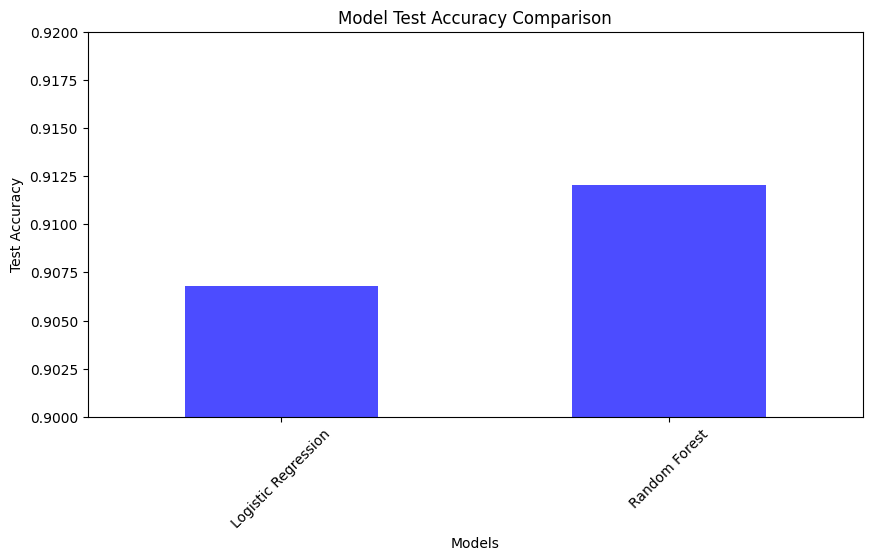

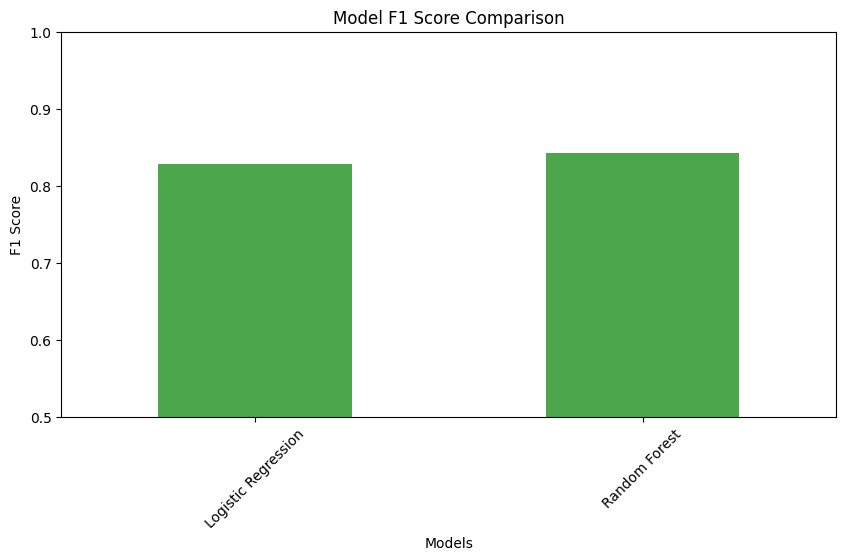

In [109]:
performance_df = pd.DataFrame(model_performance).T
performance_df
plt.figure(figsize=(10, 5))
performance_df['Test Accuracy'].plot(kind='bar', color='blue', alpha=0.7)
plt.title('Model Test Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.xlabel('Models')
plt.ylim(0.90, 0.92)  
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(10, 5))
performance_df['F1 Score'].plot(kind='bar', color='green', alpha=0.7)
plt.title('Model F1 Score Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Models')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)
plt.show()

## Finalizing the model to be used

In case of Logistic Regression, the F1 Score is the lowest among all models evaluated. This indicates that logistic regression might not be useful for balancing precision and recall, which is very important for our case.

Random Forest has slighlty high accuracy and F1 Score compared to Logistic Regression. Additionally, it can capture non-linear relationships and is more robust. 

Hence we will be using Random Forest as the final model as it provides the best balance between accuracy and the F1 Score.

In [110]:


model = RandomForestClassifier()

model.fit(X_train, y_train)

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('random_forest_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

y_pred = loaded_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print(classification_report(y_test, y_pred))


Model Evaluation Metrics:
Accuracy: 0.912781954887218
Precision: 0.9140717339567406
Recall: 0.912781954887218
F1 Score: 0.9133013915713517
Confusion Matrix:
 [[4506  326]
 [ 254 1564]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4832
           1       0.83      0.86      0.84      1818

    accuracy                           0.91      6650
   macro avg       0.89      0.90      0.89      6650
weighted avg       0.91      0.91      0.91      6650



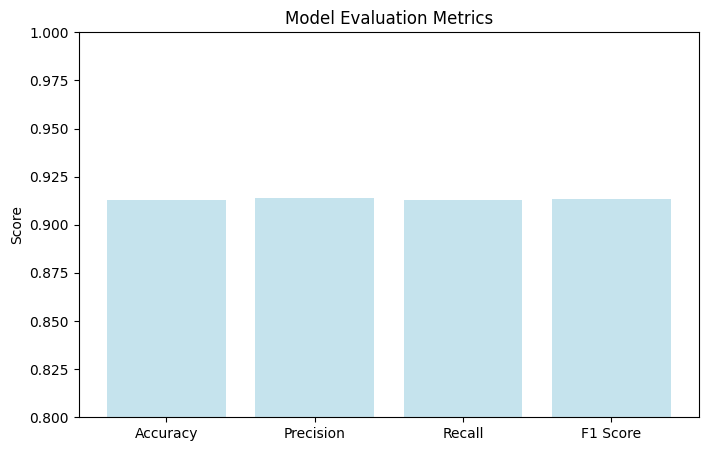

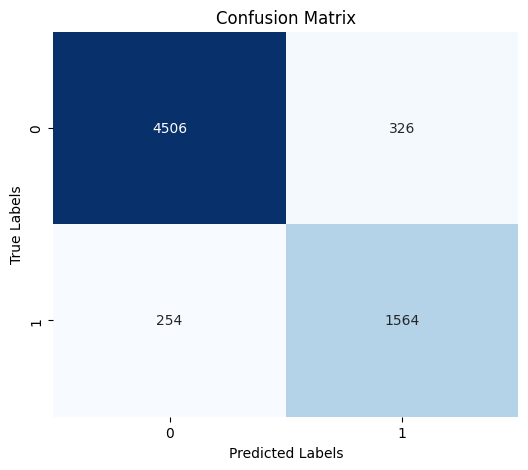

In [111]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color='lightblue', alpha=0.7)
plt.title("Model Evaluation Metrics")
plt.ylim(0.8, 1)  # Set y-axis range from 0 to 1 for better visualization
plt.ylabel("Score")
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [112]:
feature_names = X_train.columns

feature_importances = loaded_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
feature_importance = feature_importance_df[feature_importance_df['Feature'] != 'HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP']

top_features = feature_importance.sort_values(by='Importance', ascending=False)

top_feature_names = top_features.head(5)['Feature']
print("Top Features:")
print(top_feature_names)


Top Features:
5                  education_primary education
1                Employment_Employed part time
8                     income_Less than $20,000
10    COUNTY METRO/NONMETRO STATUS_Small Metro
7                       income_$75,000 or more
Name: Feature, dtype: object


Top Features:
5                  education_primary education
1                Employment_Employed part time
8                     income_Less than $20,000
10    COUNTY METRO/NONMETRO STATUS_Small Metro
7                       income_$75,000 or more
Name: Feature, dtype: object


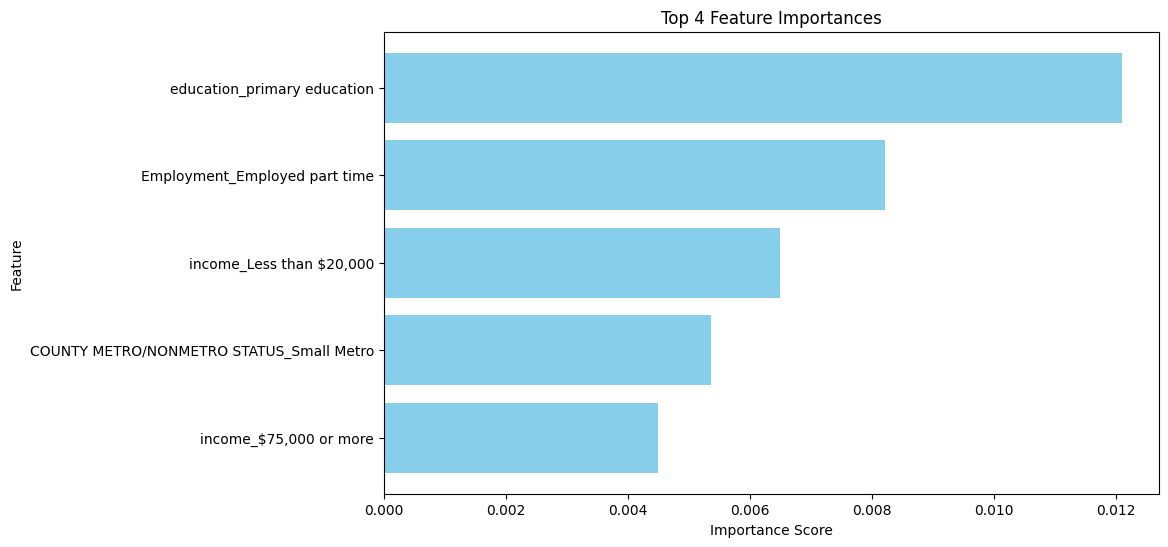

In [113]:
feature_names = X_train.columns
feature_importances = loaded_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
feature_importance = feature_importance_df[feature_importance_df['Feature'] != 'HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP']
top_features = feature_importance.sort_values(by='Importance', ascending=False).head()
top_feature_names = top_features['Feature']
top_importance_values = top_features['Importance']
print("Top Features:")
print(top_feature_names)
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_importance_values, color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 4 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


## From the above data we can conclude the following -
- Based on above data we can conclude that our initial hypothesis is correct and there is a strong relationship between socioeconomic and educational factors and mental health conditions.
- Education seems to have a strong impact on mental health. People with a high school education or less are more likely to face mental health challenges. This highlights how important education can be in shaping a person’s overall well-being.
- The data shows that people earning less than the minimum needed for basic living (around $20,000 a year) or those who are underemployed are more likely to struggle with depression. This indicates the importantance of financial stability and employment for better mental health
- This suggests that there is a need for support for those facing economic challenges 